In [5]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# load_data

In [6]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/except_hurt.zip'

-rw------- 1 root root 741372502 Nov  8 07:19 '/content/drive/My Drive/Colab Notebooks/datasets/except_hurt.zip'


In [7]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/datasets/except_hurt.zip

Archive:  /content/drive/MyDrive/Colab Notebooks/datasets/except_hurt.zip
replace train/anger/01a6c69e76d729863380b8391d780e53070cf8629ad9ffd5d06826551271fe74_│▓_30_║╨│ы_▒│┼ы&└╠╡┐╝Ў┤▄(┐д╕о║г└╠┼═ ╞ў╟╘)_20201207105109-002-005.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [10]:
train_dir = 'train'
valid_dir = 'validation'

# build model

In [3]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(206,278,3))

In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 206, 278, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 206, 278, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 206, 278, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 103, 139, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 103, 139, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 103, 139, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 51, 69, 128)       0     

In [11]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size=32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 6, 8, 512))
    labels = np.zeros(shape=(sample_count, 6))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(206,278),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size]=features_batch
        labels[i * batch_size : (i + 1) * batch_size]=labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 6000)
validation_features, validation_labels = extract_features(valid_dir, 2400)

Found 6000 images belonging to 6 classes.
Found 2400 images belonging to 6 classes.


In [12]:
train_features = np.reshape(train_features, (6000, 6 * 8 * 512))
validation_features = np.reshape(validation_features, (2400, 6 * 8 * 512))

In [16]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=6 * 8 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=22,
                    batch_size=32,
                    validation_data=(validation_features, validation_labels))

Epoch 1/22
188/188 [==============================] - 3s 12ms/step - loss: 1.6159 - acc: 0.3432 - val_loss: 1.4096 - val_acc: 0.4850
Epoch 2/22
188/188 [==============================] - 2s 10ms/step - loss: 1.3513 - acc: 0.4818 - val_loss: 1.2875 - val_acc: 0.5129
Epoch 3/22
188/188 [==============================] - 2s 10ms/step - loss: 1.2197 - acc: 0.5448 - val_loss: 1.2739 - val_acc: 0.5225
Epoch 4/22
188/188 [==============================] - 2s 10ms/step - loss: 1.1252 - acc: 0.5832 - val_loss: 1.1773 - val_acc: 0.5537
Epoch 5/22
188/188 [==============================] - 2s 10ms/step - loss: 1.0587 - acc: 0.6057 - val_loss: 1.1651 - val_acc: 0.5567
Epoch 6/22
188/188 [==============================] - 2s 9ms/step - loss: 1.0054 - acc: 0.6320 - val_loss: 1.1371 - val_acc: 0.5567
Epoch 7/22
188/188 [==============================] - 2s 9ms/step - loss: 0.9615 - acc: 0.6540 - val_loss: 1.1643 - val_acc: 0.5638
Epoch 8/22
188/188 [==============================] - 2s 10ms/step - lo

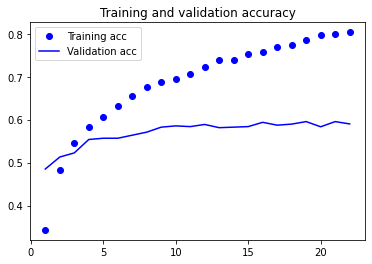

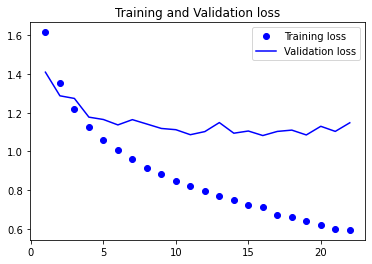

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [18]:
model.save('/content/drive/My Drive/Colab Notebooks/models/except_hurt_noaug.h5')